In [ ]:
# 事前学習済みモデルのロード
from transformers import AutoModel
import torch

model_ckpt = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [ ]:
# テキストのテンソル化
text = "this is a test"

## トークナイザー
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

inputs = tokenizer(text, return_tensors="pt")
print(f"Input tensor shape: {inputs['input_ids'].size()}") # [batch_size, n_tokens]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Input tensor shape: torch.Size([1, 6])


In [ ]:
# モデルに入れて出力
inputs = {k:v.to(device) for k,v in inputs.items()} # 各テンソル(v)をデバイスに移す
with torch.no_grad():
  outputs = model(**inputs) # inputsをそれぞれ入力(アンパック)
print(outputs)

BaseModelOutput(last_hidden_state=tensor([[[-0.1565, -0.1862,  0.0528,  ..., -0.1188,  0.0662,  0.5470],
         [-0.3575, -0.6484, -0.0618,  ..., -0.3040,  0.3508,  0.5221],
         [-0.2772, -0.4459,  0.1818,  ..., -0.0948, -0.0076,  0.9958],
         [-0.2841, -0.3917,  0.3753,  ..., -0.2151, -0.1173,  1.0526],
         [ 0.2661, -0.5094, -0.3180,  ..., -0.4203,  0.0144, -0.2149],
         [ 0.9441,  0.0112, -0.4714,  ...,  0.1439, -0.7288, -0.1619]]]), hidden_states=None, attentions=None)


In [ ]:
# 最後の隠れ状態のサイズ
outputs.last_hidden_state.size()

torch.Size([1, 6, 768])

In [ ]:
# [CLS]の隠れ状態
outputs.last_hidden_state[:,0].size()

torch.Size([1, 768])

In [ ]:
# 隠れ状態抽出関数
def extract_hidden_states(batch):
  inputs = {k:v.to(device) for k,v in batch.items() if k in tokenizer.model_input_names}
  with torch.no_grad():
    last_hidden_state = model(**inputs).last_hidden_state
  return {"hidden_states": last_hidden_state[:,0].cpu().numpy()} # [CLS]トークンに対するベクトル

In [ ]:
# 入力形式
## emotionsデータ
from datasets import load_dataset
emotions = load_dataset("dair-ai/emotion")

## トークン化
def tokenize(batch):
  return tokenizer(batch["text"], padding=True, truncation=True)
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)

## 入力形式変更
emotions_encoded.set_format("torch", columns=["input_ids", "attention_mask", "label"]) # 各ラベルのテンソルがどういったものかが分かる

README.md: 0.00B [00:00, ?B/s]

split/train-00000-of-00001.parquet:   0%|          | 0.00/1.03M [00:00<?, ?B/s]

split/validation-00000-of-00001.parquet:   0%|          | 0.00/127k [00:00<?, ?B/s]

split/test-00000-of-00001.parquet:   0%|          | 0.00/129k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [ ]:
# 全ての隠れ状態
emotions_hidden = emotions_encoded.map(extract_hidden_states, batched=True) # デフォルトのバッチサイズ1000　かなり時間かかる
emotions_hidden["train"].column_names

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

['text', 'label', 'input_ids', 'attention_mask', 'hidden_states']

In [ ]:
# 特徴行列作成
import numpy as np

X_train = np.array(emotions_hidden["train"]["hidden_states"])
X_valid = np.array(emotions_hidden["validation"]["hidden_states"])
y_train = np.array(emotions_hidden["train"]["label"])
y_valid = np.array(emotions_hidden["validation"]["label"])
X_train.shape, X_valid.shape

((16000, 768), (2000, 768))

In [ ]:
# 隠れ状態をUMAPで射影
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler

## [0, 1]にスケール
X_scaled = MinMaxScaler().fit_transform(X_train)
## UMAP初期化+fit
mapper = UMAP(n_components=2, metric="cosine").fit(X_scaled)

## 2次元埋め込みのDF作成
import pandas as pd
df_emb = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])
df_emb["label"] = y_train
df_emb.head()

,X,Y,label
0,4.470584,2.929123,0
1,-2.885281,3.237963,0
2,5.082010,6.377122,3
3,-2.316724,5.678439,2
4,-3.332008,5.258661,3


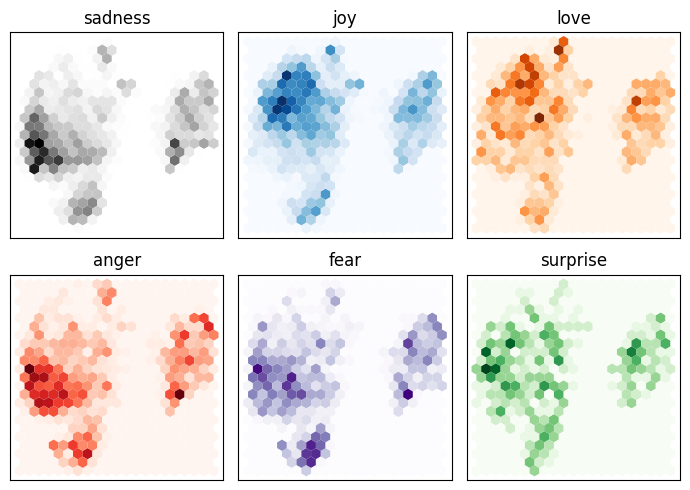

In [ ]:
# カテゴリごとに密度プロット
import matplotlib.pyplot as plt
fig, axes = plt.subplots(2, 3, figsize=(7,5))
axes = axes.flatten()
cmaps = ["Greys", "Blues", "Oranges", "Reds", "Purples", "Greens"]
labels = emotions["train"].features["label"].names

## プロット
for i, (label, cmap) in enumerate(zip(labels, cmaps)):
  df_emb_sub = df_emb.query(f"label == {i}") # ラベルごとに取り出し
  axes[i].hexbin(df_emb_sub["X"], df_emb_sub["Y"], cmap=cmap,
                 gridsize=20, linewidth=(0,))
  axes[i].set_title(label)
  axes[i].set_xticks([]), axes[i].set_yticks([])

## 描画
plt.tight_layout()
plt.show()

In [ ]:
# ロジスティック回帰で分類モデル学習
from sklearn.linear_model import LogisticRegression

## 確実に収束させるためmax_iterをデフォルト(100)より多く設定
lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train, y_train)
lr_clf.score(X_valid, y_valid) # 正解率：0.6335

0.6335

In [ ]:
# ベースライン測定
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="most_frequent") # 多数派を選択
dummy_clf.fit(X_train, y_train)
dummy_clf.score(X_valid, y_valid) # 正解率：0.352

0.352

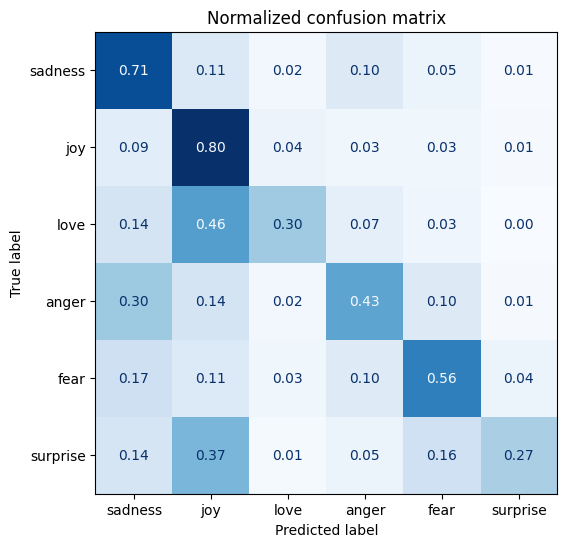

In [ ]:
# 混同行列描画
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_preds, y_true, labels):
  cm = confusion_matrix(y_true, y_preds, normalize="true")
  fig, ax = plt.subplots(figsize=(6, 6))
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
  disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
  plt.title("Normalized confusion matrix")
  plt.show()

y_preds = lr_clf.predict(X_valid)
plot_confusion_matrix(y_preds, y_valid, labels)